<a href="https://colab.research.google.com/github/sanyakapoor27/PCOS-Classification-with-VGG16-SVM/blob/main/Classification_of_pcos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this colab file, we have built a classification model for PCOS into infected and not infected categories using SVM and VGG16 with pre-trained ImageNet weights as our feature extractor.

First, we start by installing tensorflow and importing the necessary packages and libraries.

In [ ]:
!pip install tensorflow

In [ ]:
#importing necessary packages
import os
import tensorflow as tf
import numpy as np
import cv2
from tensorflow import keras
import matplotlib.pyplot as plt
import shutil
import hashlib
from hashlib import md5
import imageio.v2 as imageio
from imageio import imread
import pandas as pd
from keras.utils import img_to_array, array_to_img
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from skimage.filters import threshold_multiotsu
from skimage import img_as_ubyte
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.svm import SVC
from sklearn import metrics
import plotly.graph_objects as go
from sklearn.metrics import classification_report, accuracy_score
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from scipy.ndimage import distance_transform_edt

In [ ]:
#setting gpu memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

Due to lack of open source PCOS datasets with sufficient information being available, I have compiled two datasets together to be used and downloaded it through Google Drive. One being on [Kaggle](https://www.kaggle.com/datasets/anaghachoudhari/pcos-detection-using-ultrasound-images) and the other being [Dataverse](https://dataverse.telkomuniversity.ac.id/dataset.xhtml?persistentId=doi:10.34820/FK2/QVCP6V) by Telkom University, Indonesia

In [ ]:
#downloading the dataset from google drive
!gdown https://drive.google.com/uc?id=1PMNujSaJ0h0PwAyRz_d2RR4wPZ29MVgh

Downloading...
From: https://drive.google.com/uc?id=1PMNujSaJ0h0PwAyRz_d2RR4wPZ29MVgh
To: /content/pcos.zip
100% 65.9M/65.9M [00:00<00:00, 178MB/s]


In [ ]:
#unzipping
!unzip pcos.zip

Archive:  pcos.zip
   creating: pcos/
   creating: pcos/data/
   creating: pcos/data/pcos/
   creating: pcos/data/pcos/infected/
  inflating: pcos/data/pcos/infected/img1.jpg  
  inflating: pcos/data/pcos/infected/img10.jpg  
  inflating: pcos/data/pcos/infected/img2.jpg  
  inflating: pcos/data/pcos/infected/img3.jpg  
  inflating: pcos/data/pcos/infected/img4.jpg  
  inflating: pcos/data/pcos/infected/img5.jpg  
  inflating: pcos/data/pcos/infected/img6.jpg  
  inflating: pcos/data/pcos/infected/img7.jpg  
  inflating: pcos/data/pcos/infected/img8.jpg  
  inflating: pcos/data/pcos/infected/img_0_1023.jpg  
  inflating: pcos/data/pcos/infected/img_0_1033.jpg  
  inflating: pcos/data/pcos/infected/img_0_1071.jpg  
  inflating: pcos/data/pcos/infected/img_0_1075.jpg  
  inflating: pcos/data/pcos/infected/img_0_1079.jpg  
  inflating: pcos/data/pcos/infected/img_0_1083.jpg  
  inflating: pcos/data/pcos/infected/img_0_1087.jpg  
  inflating: pcos/data/pcos/infected/img_0_1088.jpg  
  infl

# Exploratory Data Analysis

In this section, we will explore our image dataset by looking at the different classes we have, the total number of images and finding duplicated images in the dataset.

In [ ]:
data_dir = "/content/pcos/data/pcos"
infected_dir = os.path.join(data_dir, 'infected')
notinfected_dir = os.path.join(data_dir, 'notinfected')

In [ ]:
print("The two classes inside this dataset are: ")
for image_class in os.listdir(data_dir):
  print(image_class)

The two classes inside this dataset are: 
notinfected
infected


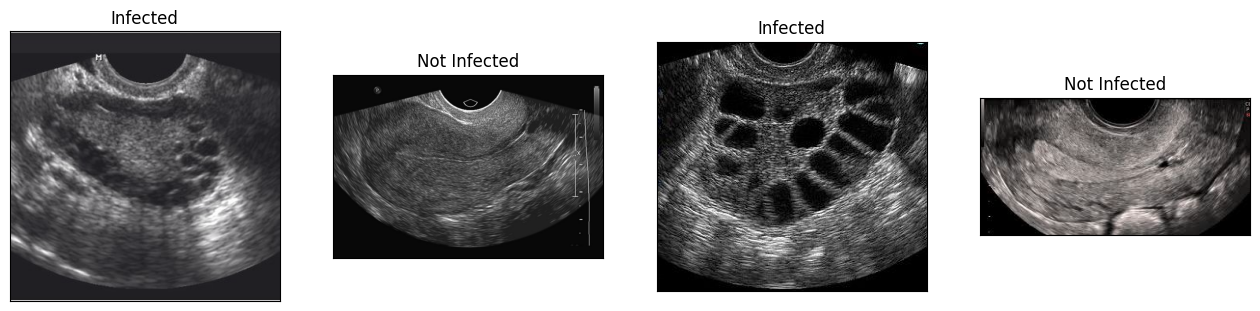

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(141)
image1 =cv2.imread("/content/pcos/data/pcos/infected/img1.jpg")
plt.imshow(image1)
plt.title("Infected")
plt.xticks([])
plt.yticks([])
plt.subplot(142)
image2 = cv2.imread("/content/pcos/data/pcos/notinfected/img2.png")
plt.imshow(image2)
plt.title("Not Infected")
plt.xticks([])
plt.yticks([])
plt.subplot(143)
image3 = cv2.imread("/content/pcos/data/pcos/infected/img3.jpg")
plt.imshow(image3)
plt.title("Infected")
plt.xticks([])
plt.yticks([])
plt.subplot(144)
image4 = cv2.imread("/content/pcos/data/pcos/notinfected/img4.jpg")
plt.imshow(image4)
plt.title("Not Infected")
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
#the number of images inside the folders

inf_count = len(os.listdir(infected_dir))
notinf_count = len(os.listdir(notinfected_dir))
print("The total number of infected images: " + str(inf_count))
print ("The total number of non infected images: " + str(notinf_count))

The total number of infected images: 781
The total number of non infected images: 1143


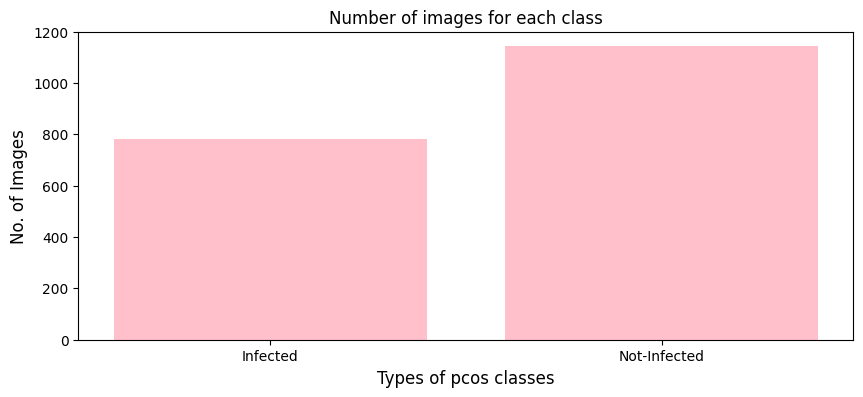

In [ ]:
#showing a visual representation
x_axis = ['Infected', 'Not-Infected']
y_axis = [int(inf_count), int(notinf_count)]

fig = plt.figure(figsize=(10, 4))
plt.ylim(0, 1200)
plt.bar(x_axis, y_axis, color='pink')
plt.title('Number of images for each class')
plt.xlabel('Types of pcos classes', fontsize=12)
plt.ylabel('No. of Images', fontsize=12)
plt.show()

We've created a function to find the hash value of an image using the md5 algorithm. Duplicates can lead to biases during training therefore, it is important to remove them. We do this by saving the index of every unique hash value in a dictionary and when found to be repeated they get appended in a list with the index of the orignal hash value.

In [ ]:
#function to give the hash value of an image
def image_hash(imagepath):
  with open(imagepath, 'rb') as f:
    return md5(f.read()).hexdigest()

In [ ]:
#function to find duplicates of an image by its hash value

def find_duplicates(dir_name):
  #empty list to store index of duplicate images
  duplicates =[]

  #empty dictionary to save index of non duplicated images
  hash_keys = {}

  for index, imgfile in enumerate(os.listdir(dir_name)):
    imagepath = (os.path.join(dir_name, imgfile))
    filehash = image_hash(imagepath)
    if filehash not in hash_keys:
      hash_keys[filehash] = index
    else:
      #if same hash value is found it is added in the list
      duplicates.append((index, hash_keys[filehash]))

  return duplicates

In [ ]:
#function to plot duplicates

def plot_duplicates(dir_name, list_name):

  os.chdir(dir_name)
  img_list = os.listdir(dir_name)

  for img_indexes in list_name:
    try:
      plt.subplot(121), plt.imshow(imread(img_list[img_indexes[1]])),
      plt.title(img_indexes[1]), plt.xticks([]), plt.yticks([])

      plt.subplot(122), plt.imshow(imread(img_list[img_indexes[0]]))
      plt.title(str(img_indexes[0]) + ' duplicate'), plt.xticks([]), plt.yticks([])
      plt.show()

    except OSError as e:
      continue

In [ ]:
#function to remove duplicates

def remove_duplicates(dir_name, list_name):
  img_list = os.listdir(dir_name)
  for img_indexes in list_name:
    os.remove(img_list[img_indexes[0]])

In [ ]:
inf_duplicates = find_duplicates(infected_dir)
print(inf_duplicates)
print()
print("The total number of duplicate images for infected PCOS are: " + str(len(inf_duplicates)))

[(327, 152), (377, 298)]

The total number of duplicate images for infected PCOS are: 2


<ipython-input-14-9409b22a943e>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.subplot(121), plt.imshow(imread(img_list[img_indexes[1]])),
<ipython-input-14-9409b22a943e>:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.subplot(122), plt.imshow(imread(img_list[img_indexes[0]]))


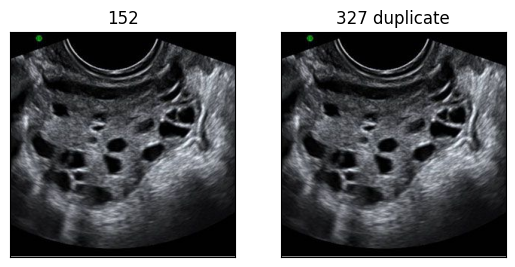

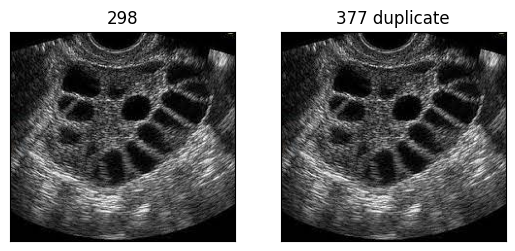

In [ ]:
plot_duplicates(infected_dir, inf_duplicates)

In [ ]:
remove_duplicates(infected_dir, inf_duplicates)
print("Number of duplicates left: ")
find_duplicates(infected_dir)

Number of duplicates left: 


[]

In [ ]:
notinf_duplicates = find_duplicates(notinfected_dir)
print(notinf_duplicates)
print()
print("The total number of duplicate images for not infected PCOS are: " + str(len(notinf_duplicates)))

[(698, 682)]

The total number of duplicate images for not infected PCOS are: 1


<ipython-input-14-9409b22a943e>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.subplot(121), plt.imshow(imread(img_list[img_indexes[1]])),
<ipython-input-14-9409b22a943e>:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.subplot(122), plt.imshow(imread(img_list[img_indexes[0]]))


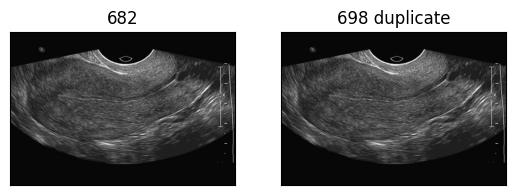

In [ ]:
plot_duplicates(notinfected_dir, notinf_duplicates)

In [ ]:
remove_duplicates(notinfected_dir, notinf_duplicates)
print("Number of duplicates left: ")
find_duplicates(notinfected_dir)

Number of duplicates left: 


[]

In [ ]:
inf_count = len(os.listdir(infected_dir))
notinf_count = len(os.listdir(notinfected_dir))
print("Total number of infected PCOS images now: " + str(inf_count))
print("Total number of not infected PCOS images now: " + str(notinf_count))

Total number of infected PCOS images now: 779
Total number of not infected PCOS images now: 1142


In [ ]:
os.chdir("/content/")

# Pre-processing

Preprocessing is a vital step for classification of medical data. We've preprocessed our ultrasound images by increasing their contrast and brightness around the follicle regions. Ultrasound images are affected by Speckle noise. Therefore, to remove it we've applied Gaussian Filter. To tone down the effect of Gaussian filter and enhance the image Adaptive Histogram Equalization has been used on the image. Morphological operations like Erosion and Dilation are done to remove small noise structures while preserving the important features. Finally, the image is segmented by Multi-OTSU threshold with threshold value of 4.

In [ ]:
def preprocessing(dir_name):

  labels = {}
  preprocessed_labels = []
  preprocessed_image = []
  i = 0

  for image_class in os.listdir(dir_name):
    labels[i] = image_class
    for img in os.listdir(os.path.join(dir_name, image_class)):
      path = os.path.join(dir_name, image_class, img)

      image = cv2.imread(path)
      image = cv2.resize(image, (224, 224))
      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

      intensity_img = cv2.convertScaleAbs(gray, alpha=2.5, beta=40)

      #applying gaussian filter for noise reduction
      fltr_image = cv2.GaussianBlur(intensity_img, (5,5), 0)

      #applying adaptive histogram equalization for contrast enhancement
      clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
      enhanced_image = clahe.apply(fltr_image)

      #applying erosion to remove noise
      kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
      erode = cv2.erode(enhanced_image, kernel, iterations=1)

      #applying dilation
      dilate = cv2.dilate(erode, kernel, iterations=1)

      #applying otsu thresholding
      thresh = threshold_multiotsu(dilate, classes=4)
      region = np.digitize(dilate, bins=thresh)
      output = cv2.normalize(region, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
      output = cv2.cvtColor(output, cv2.COLOR_GRAY2RGB)

      preprocessed_image.append(output)
      preprocessed_labels.append(i)

    i+=1

  preprocessed_image = np.array(preprocessed_image)
  preprocessed_labels = np.array(preprocessed_labels)
  print("Preprocessing is complete!")
  return preprocessed_image, preprocessed_labels, labels

In [ ]:
#visualizing the image preprocessing process

image = cv2.imread("/content/pcos/data/pcos/infected/img4.jpg")
image = cv2.resize(image, (224, 224))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#applying intensity transformation
intensity_img = cv2.convertScaleAbs(gray, alpha=2.5, beta=40)

#applying gaussian filter for noise reduction
fltr_image = cv2.GaussianBlur(intensity_img, (5,5), 0)

#applying adaptive histogram equalization for contrast enhancement
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enhanced_image = clahe.apply(fltr_image)

#applying erosion to remove noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
erode = cv2.erode(enhanced_image, kernel, iterations=1)

#applying dilation
dilate = cv2.dilate(erode, kernel, iterations=1)

#applying multi otsu thresholding
thresh = threshold_multiotsu(dilate, classes=4)
regions = np.digitize(dilate, bins=thresh)

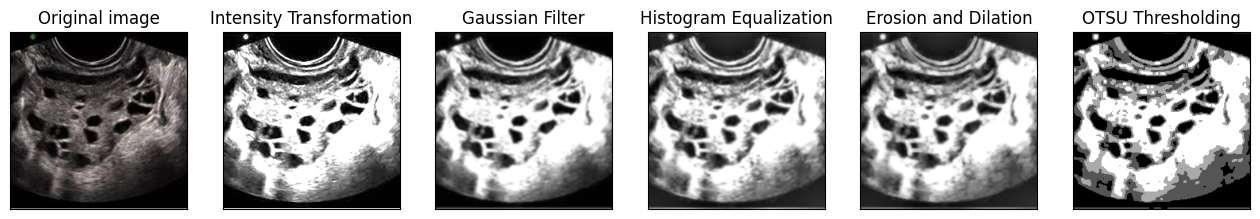

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(161)
plt.imshow(image, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title('Original image')
plt.subplot(162)
plt.imshow(intensity_img, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title('Intensity Transformation')
plt.subplot(163)
plt.imshow(fltr_image, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title('Gaussian Filter')
plt.subplot(164)
plt.imshow(enhanced_image, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title('Histogram Equalization')
plt.subplot(165)
plt.imshow(dilate, cmap ="gray")
plt.xticks([])
plt.yticks([])
plt.title('Erosion and Dilation')
plt.subplot(166)
plt.imshow(regions, cmap="gray")
plt.title('OTSU Thresholding')
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
#applying the preprocessing function on our data directory and then saving them
x, y, labels = preprocessing(data_dir)

Preprocessing is complete!


In [ ]:
labels

{0: 'notinfected', 1: 'infected'}

# Train-Test Split

We've split the data into a ratio of 80:20 for training and testing respectively. Separate folders for train and test are created and images are divided following the above mentioned ratio.

In [ ]:
#splitting our preprocessed images in 80:20 for training and testing respectively
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
#making train and test folders

!apt-get install tree

%mkdir train test train/infected train/notinfected test/infected test/notinfected
!tree -d

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (42.5 kB/s)
Selecting previously unselected package tree.
(Reading database ... 120831 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...
.
├── pcos
│   └── data
│       └── pcos
│           ├── infected
│           └── notinfected
├── sample_data
├── test
│   ├── infected
│   └── notinfected
└── train
    ├── infected
    └── notinfected

12 directories


In [ ]:
train_dir = "/content/train"
test_dir = "/content/test"

In [ ]:
#function to save images to directory

def save_images(x_set, y_set, dir):
  i = 0
  for (img, imgclass) in zip(x_set, y_set):
    if imgclass == 0:
      cv2.imwrite(os.path.join(dir, 'infected', str(i) + '.jpg' ), img)
    else:
      cv2.imwrite(os.path.join(dir, 'notinfected', str(i) + '.jpg'), img)
    i+=1
  print("Images successfully saved!")

In [ ]:
save_images(x_train, y_train, train_dir)
save_images(x_test, y_test, test_dir)

Images successfully saved!
Images successfully saved!


In [ ]:
print("Number of infected images in train: " + str(len(os.listdir(os.path.join('train', 'infected')))))
print("Number of not infected images in train: " + str(len(os.listdir(os.path.join('train', 'notinfected')))))
print()
print("Number of infected images in test: " + str(len(os.listdir(os.path.join('test', 'infected')))))
print("Number of not infected images in test: " + str(len(os.listdir(os.path.join('test', 'notinfected')))))

Number of infected images in train: 916
Number of not infected images in train: 620

Number of infected images in test: 226
Number of not infected images in test: 159


# Data Augmentation

Data Augmentation helps us to diversify the data we feed the training model. We've used the ImageDataGenerator class from Keras for our training directory and applied the following augmentations to our training data such as rotation, flipping, width shift etc.

In [ ]:
#listing the augmentations to be applied to training images using ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="constant",
    rescale = 1./255,
    zoom_range =[0.2, 0.1],
    brightness_range=[0.3, 0.2],
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    color_mode='rgb',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle =True,
    seed=42,
)

Found 1536 images belonging to 2 classes.


In [ ]:
#using ImageDataGenerator class for test images (only rescaling)
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = train_datagen.flow_from_directory(
    test_dir,
    color_mode='rgb',
    target_size=(224, 224),
    batch_size=1,
    class_mode=None,
    shuffle =False,
    seed=42,
)

Found 385 images belonging to 2 classes.


In [ ]:
#for visualizing
demo_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="constant",
    brightness_range=[0.3, 0.4],
    horizontal_flip=True,
)

In [ ]:
os.mkdir('preview')

In [ ]:
#for visualizing
x_demo = x_train[0]
x_demo = np.array(x_demo).reshape(1,224, 224, 3)

i = 0
for batch in demo_datagen.flow(x_demo, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break

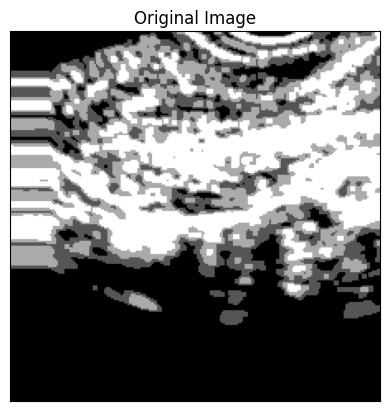

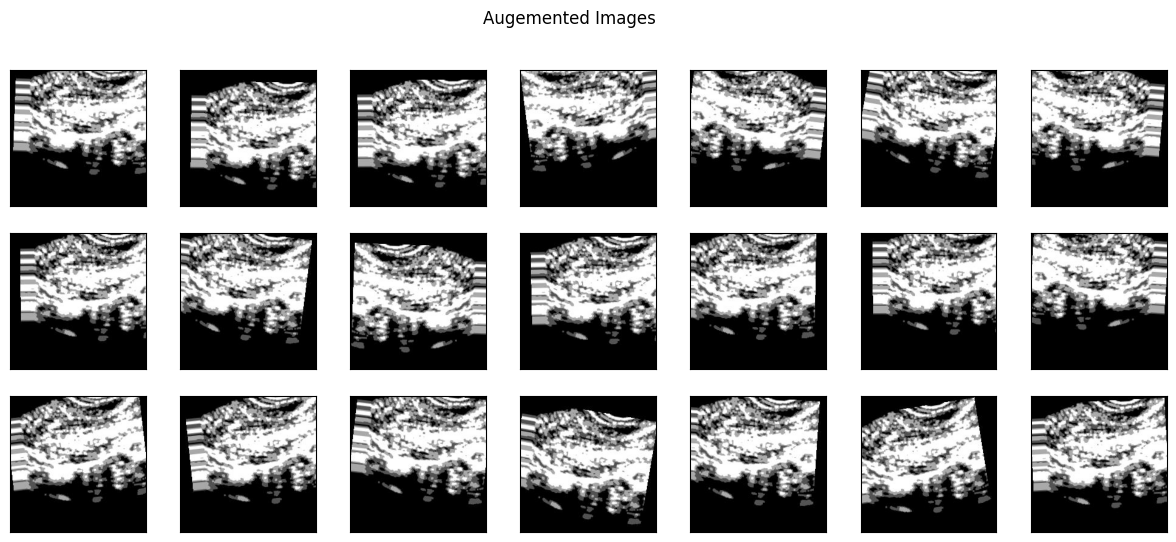

In [ ]:
#showing the orignal and augmented images
plt.imshow(x_train[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

# Feature Extraction

In feature extraction of our augmented images we've applied the approach of Transfer Learning. We've imported the VGG16 model from Keras and assigned it ImageNet pre-trained weights. With this model we'll now extract features from our train_generator.

In [ ]:
#imported VGG16 with ImageNet weights
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#as we're working with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#extracting features using our VGG16 model
feature_extractor = VGG_model.predict(train_generator)

48/48 [==============================] - 32s 408ms/step


In [ ]:
#flattening the extracted features
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

In [ ]:
X_for_SVM = features

In [ ]:
train_labels = train_generator.classes
test_labels = test_generator.classes

# SVM (Linear Kernel)

From our extracted 25088 features we've selected the best using the Chi Square selection test. We've further used two SVM models for classification, SVM with linear kernel and rbf kernel both with soft margins.We use GridSearchCV to find the best hyperparameters for our data and showcase it in the above model.  We've evaluated them using Accuracy, Precision, F1 Score and Recall.

In [ ]:
#finding the best features for training from the ones extracted through Chi-square test
chi2_features = SelectKBest(chi2, k=3)
X_best_features = chi2_features.fit_transform(X_for_SVM, train_labels)
print("Orignal features: ", X_for_SVM.shape[1])
print("Reduced features: ", X_best_features.shape[1])

Orignal features:  25088
Reduced features:  3


In [ ]:
#finding test features with our VGG16 model
x_test_features = VGG_model.predict(test_generator)
x_test_features = x_test_features.reshape(x_test_features.shape[0], -1)

385/385 [==============================] - 6s 13ms/step


In [ ]:
#finding the best features for testing data
chi2_features = SelectKBest(chi2, k=3)
x_btest_features = chi2_features.fit_transform(x_test_features, test_labels)
print("Orignal features: ", x_test_features.shape[1])
print("Reduced features: ", x_btest_features.shape[1])

Orignal features:  25088
Reduced features:  3


In [ ]:
#creating a dictionary with various parameters and their possible values
grid_parameter = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'class_weight': [None, 'balanced'],
}

In [ ]:
#using the above defined dictionary to go through all possibilties using GridSearchCV and find the best hyperparameters
grid = GridSearchCV(SVC(), grid_parameter, refit=True, verbose=2)
grid.fit(X_best_features, train_labels)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV] END C=0.1, class_weight=None, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=None, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=None, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=None, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=None, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .C=0.1, class_weight=None, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .C=0.1, class_weight=None, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .C=0.1, class_weight=None, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .C=0.1, class_weight=None, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .C=0.1, class_weight=None, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ..C=0.1, class_weight=None, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, class_weight=None, gamm

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'class_weight': [None, 'balanced'],
                         'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=2)

In [ ]:
print(grid.best_params_)

{'C': 100, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}


In [ ]:
#defining our first svm classifier model
svm_classifier_1 = SVC(kernel='linear', C=100, gamma=1, class_weight='balanced')

In [ ]:
#fitting it on best training features
svm_classifier_1.fit(X_best_features, train_labels)

SVC(C=100, class_weight='balanced', gamma=1, kernel='linear')

In [ ]:
#predicting test features
prediction1_SVM = svm_classifier_1.predict(x_btest_features)

In [ ]:
classification_report1 = classification_report(test_labels, prediction1_SVM)
print(classification_report1)

              precision    recall  f1-score   support

           0       0.73      0.73      0.73       226
           1       0.61      0.61      0.61       159

    accuracy                           0.68       385
   macro avg       0.67      0.67      0.67       385
weighted avg       0.68      0.68      0.68       385



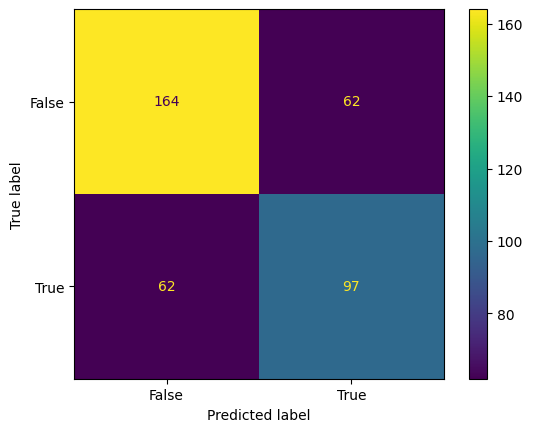

In [ ]:
confusion_matrix = metrics.confusion_matrix(test_labels, prediction1_SVM)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix= confusion_matrix, display_labels=[False, True])
cm_display.plot()
plt.show()

In [ ]:
Z = lambda X,Y: (-svm_classifier_1.intercept_[0]-svm_classifier_1.coef_[0][0]*X-svm_classifier_1.coef_[0][1]*Y) / svm_classifier_1.coef_[0][2]
# The equation of the separating plane is given by all x so that np.dot(svc.coef_[0], x) + b = 0.

#for separating plane
trace1 = go.Mesh3d(x = X_best_features[:,0], y = X_best_features[:,1], z = Z(X_best_features[:,0], X_best_features[:,1]))
#for vector plots
trace2 = go.Scatter3d(x=X_best_features[:,0], y=X_best_features[:,1],z=X_best_features[:,2],mode='markers',marker = dict(size = 3,color = y_train,colorscale = 'Viridis'))
data=[trace1,trace2]
fig = go.Figure(data=data,layout={})
fig.show()

# SVM (rbf Kernel)

In [ ]:
#defining svm classifier 2
svm_classifier_2 = SVC(kernel='rbf', C=100, gamma=1, class_weight='balanced')

In [ ]:
#fitting it on train features
svm_classifier_2.fit(X_best_features, train_labels)

SVC(C=100, class_weight='balanced', gamma=1)

In [ ]:
#predicting test features
prediction2_SVM = svm_classifier_2.predict(x_btest_features)

In [ ]:
#evaluation metrics
classification_report2 = classification_report(test_labels, prediction2_SVM)
print(classification_report2)

              precision    recall  f1-score   support

           0       0.74      0.70      0.72       226
           1       0.60      0.65      0.63       159

    accuracy                           0.68       385
   macro avg       0.67      0.68      0.67       385
weighted avg       0.69      0.68      0.68       385



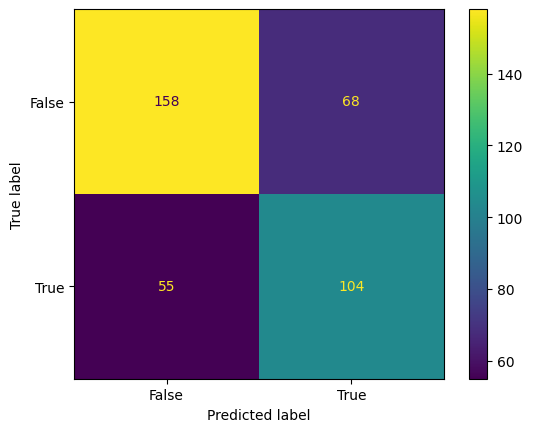

In [ ]:
#confusion matrix to see true positives, true negatives, false positives, false negatives
confusion_matrix = metrics.confusion_matrix(test_labels, prediction2_SVM)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix= confusion_matrix, display_labels=[False, True])
cm_display.plot()
plt.show()

In [ ]:
x_range = np.linspace(X_best_features[:, 0].min(), X_best_features[:, 0].max(), 50)
y_range = np.linspace(X_best_features[:, 1].min(), X_best_features[:, 1].max(), 50)
x_grid, y_grid = np.meshgrid(x_range, y_range)
z_grid = svm_classifier_2.decision_function(np.c_[x_grid.ravel(), y_grid.ravel(),np.zeros_like(x_grid.ravel())]).reshape(x_grid.shape)

#creating a 3D surface plot
fig = go.Figure(data=[
    go.Surface(x=x_grid, y=y_grid, z=z_grid, opacity=0.8)
])

#adding the data points
fig.add_trace(go.Scatter3d(x=X_best_features[:, 0], y=X_best_features[:, 1], z=X_best_features[:, 2], mode='markers', marker=dict(color=y, size=5)))

#show the plot
fig.show()